# Supervised Learning for HR Separations
# July 13, 2015
1. Return to the ETL to correct the dataset
    * no longer do I need to labelEncode GRADE
    * try to use bear
#### Define the source repo (for bear)
    * 'C:/Users/kesj/code/'
2. Define the correct working directories
    * stgdirlocal = 'C:/Users/kesj/Documents/projects/HRattrition/EDA'

In [1]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')

In [2]:
repodir = 'C:\\Users\kesj\\code\\'
stgdirlocal = 'C:\\Users\\kesj\\Documents\\projects\\HRattrition\\EDA'

In [3]:
os.chdir(repodir)

In [4]:
import bear.bear as br

In [5]:
os.chdir(stgdirlocal)

#First load the US unemployment measures

In [6]:
unempl_raw = pd.read_csv('../other_data/us_unemployment_monthly_seas.csv')
unempl=pd.melt(unempl_raw,id_vars='Year')
unempl.sort('Year', inplace=True)
unempl['date'] = unempl[['Year','variable']].apply(lambda x: pd.to_datetime(x[1]+str(x[0]),format='%b%Y'),axis=1)
unempl.sort('date',inplace=True)
unempl.head()

,Year,variable,value,date
0,1987,Jan,6.6,1987-01-01
29,1987,Feb,6.6,1987-02-01
58,1987,Mar,6.6,1987-03-01
87,1987,Apr,6.3,1987-04-01
116,1987,May,6.3,1987-05-01


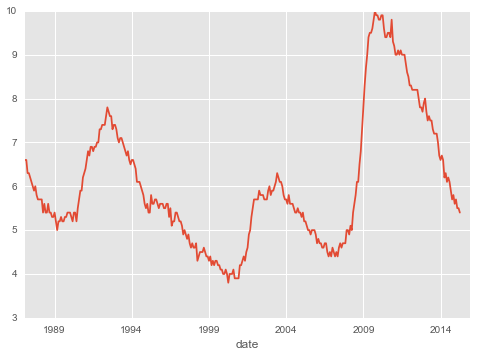

In [7]:
unempl.set_index('date',inplace=True)
unempl['value'].plot()

### Some helper functions

In [6]:
def assign_unempl_rate(my_date,unempl):
    try :
        un_rate = unempl[unempl.index <= my_date]['value'].values[-1]
    except IndexError:
        un_rate = unempl['value'].ix[0]
        
    return un_rate

# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = np.nan
    return out_zip

In [7]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

## Load the un-filled file and combine with EAS data

In [9]:
datafile = 'employee_dataframe.ssv'
emplraw = pd.read_csv(datafile,sep=';',dtype={'KEY':np.str})
print emplraw.shape
emplraw.drop('Unnamed: 0',axis=1,inplace=True)

emplraw.drop('PER_ORG',axis=1,inplace=True) #remove PER_ORG

(243010, 185)


## Clean up some of the columns
* remove grade of UNS
* remove negative tenures

In [10]:
len(emplraw[emplraw.TOT_MO_SERVICE_SFI< 0]) # check that all have positive mos

143

In [11]:
emplpos = emplraw[emplraw.TOT_MO_SERVICE_SFI>=0].copy()
print np.shape(emplpos)

## remove seasonal/interns
print "{0} employees with the GRADE UNS will be dropped.".format((emplpos.GRADE=='UNS').sum())
empl1=emplpos[emplpos.GRADE!='UNS'].copy()
print len(empl1)

(242867, 183)
43521 employees with the GRADE UNS will be dropped.
199346


In [8]:
### load the later data to get benefit info
empl8 = pd.read_csv('employee_dataframe8.tsv',sep='\t',dtype={'KEY':np.str, 'zip5':np.str})
empl8.columns

Index([u'ACTRES1', u'ACTRES10', u'ACTRES2', u'ACTRES3', u'ACTRES4', u'ACTRES5',
       u'ACTRES6', u'ACTRES7', u'ACTRES8', u'ACTRES9', 
       ...
       u'Tenure_tdelta', u'status', u'Tenure_years', u'HAVE_INS', u'HAVE_DEP',
       u'DEP_COUNT', u'sep_status', u'mar_status', u'zip5', u'retired'],
      dtype='object', length=184)

In [13]:
empl_bene=pd.merge(empl1,empl8,on='KEY',how='left')
print empl_bene.shape

(199346, 366)


In [14]:
empl_bene.columns

Index([u'ACTRES1_x', u'ACTRES10_x', u'ACTRES2_x', u'ACTRES3_x', u'ACTRES4_x',
       u'ACTRES5_x', u'ACTRES6_x', u'ACTRES7_x', u'ACTRES8_x', u'ACTRES9_x', 
       ...
       u'Tenure_tdelta_y', u'status_y', u'Tenure_years', u'HAVE_INS',
       u'HAVE_DEP', u'DEP_COUNT', u'sep_status', u'mar_status', u'zip5',
       u'retired'],
      dtype='object', length=366)

In [31]:
ycolumns = [c for c in empl_bene.columns if c.endswith('_y')]
xcolumns = [c for c in empl_bene.columns if c.endswith('_x')]
print len(ycolumns), len(xcolumns)

175 175


###remove grades starting with 'L' and 'AT'
As we discussed, you’re already excluding seasonal employees, interns, and agency interns. Let’s also exclude the L-Level executive employees are in the LDSH job group with job grades L1 to L10 (i.e., all job grades starting with “L”). Let’s also exclude Air Transportation as we don’t foresee applying the model to them either. Their job group is AIRT with job grades AT1 to AT8 (i.e., all job grades starting with “AT”).

In [15]:
list_of_grades = empl_bene.GRADE_x.unique()
print len(list_of_grades)
grades_to_drop = [x for x in map(str,list_of_grades) if (x.startswith('L') or x.startswith('AT'))]
print len(grades_to_drop), grades_to_drop

164
24 ['LS2', 'LP1', 'L5', 'LS1', 'L7', 'L6', 'L9', 'LS3', 'L10', 'LM1', 'AT5', 'LM2', 'L8', 'L4', 'AT7', 'AT2', 'L2', 'L3', 'AT3', 'L1', 'AT1', 'AT6', 'AT4', 'AT8']


In [17]:
print grades_to_drop,len(grades_to_drop)
grades_to_drop.remove('LS2')
grades_to_drop.remove('LS1')
grades_to_drop.remove('LS3')
grades_to_drop.remove('LM1')
grades_to_drop.remove('LM2')
grades_to_drop.remove('LP1')
print len(grades_to_drop),grades_to_drop

['LS2', 'LP1', 'L5', 'LS1', 'L7', 'L6', 'L9', 'LS3', 'L10', 'LM1', 'AT5', 'LM2', 'L8', 'L4', 'AT7', 'AT2', 'L2', 'L3', 'AT3', 'L1', 'AT1', 'AT6', 'AT4', 'AT8'] 24
18 ['L5', 'L7', 'L6', 'L9', 'L10', 'AT5', 'L8', 'L4', 'AT7', 'AT2', 'L2', 'L3', 'AT3', 'L1', 'AT1', 'AT6', 'AT4', 'AT8']


In [18]:
print "removing these {0} grades removes {1} employees".format(len(grades_to_drop),len(empl_bene[empl_bene.GRADE_x.isin(grades_to_drop)]))
empl=empl_bene[~empl_bene.GRADE_x.isin(grades_to_drop)].copy()
print np.shape(empl)

removing these 18 grades removes 581 employees
(198765, 366)


## remove those with unknown/other sep_status

In [20]:
empl = empl[empl.sep_status <=2]
print np.shape(empl)

(197950, 367)


In [21]:
## create a column for terminated (i.e. separated but NOT retired)
empl['terminated']= 0
my_rows = empl[(empl.status_y==1) & (empl.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(empl),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
empl.loc[my_rows,'terminated']=1
print sum(empl.terminated)

Out of 197950 rows, 105693 are separated and not retired.
105693


###Take a Time Slice to consider
only after 2002-01-01

In [22]:
date0 = '2002-01-01'
em2002 = empl.ix[empl.TERMINATION_DT_x>=date0].copy()
print date0, len(em2002)
print "--------- STATUS "
print em2002.status_y.value_counts()
print "--------- TERMINATED"
print em2002.terminated.value_counts()
print "--------- RETIRED"
print em2002.retired.value_counts()

2002-01-01 134237
--------- STATUS 
0    69476
1    64761
dtype: int64
--------- TERMINATED
0    84413
1    49824
dtype: int64
--------- RETIRED
0    119299
1     14938
dtype: int64


In [23]:
## create timestamps for columns that are timestamps
em2002[['hire_tstmp','term_tstmp','birth_tstmp']] = em2002[['HIRE_DT_x','TERMINATION_DT_x','BIRTHDATE_x']].apply(lambda x:pd.to_datetime(x))
## add a column for age at hire date
hire_age_tdelta = em2002['hire_tstmp']-em2002['birth_tstmp']
# convert to days, months, or years
em2002['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

In [24]:
em2002.SHIFT_x.value_counts()

1    130622
N      1909
2      1303
3       403
dtype: int64

In [25]:
all_columns_0 = em2002.columns.tolist()
len(all_columns_0)

371

In [26]:
cols_to_survival = ['GRADE_y','JOB_FAMILY_y','JOB_FUNCTION_y','LOCATION_y','JOBCODE_y']
cols_to_cat_encode = ['EMPL_CLASS_y','EEO1CODE_y','EMPL_TYPE_y','FULL_PART_TIME_y']
cols_to_label_encode = ['LOC_TYPE_DESCR_SFI_y','LOC_STATE_y','EXT_FUNC_ID_SFI_y','FUNC_ID_SFI_y','FLOR_SFI_y','COMPANY_y','DIVISION_CODE_SFI_y']

In [32]:
keep_categorical_cols = []
keep_categorical_cols+=cols_to_survival
keep_categorical_cols+=cols_to_cat_encode
keep_categorical_cols+=cols_to_label_encode
keep_categorical_cols.append('FLSA_STATUS_y')
keep_categorical_cols.append('SHIFT_y')
keep_categorical_cols.append('ETHNIC_GROUP_y')
print len(keep_categorical_cols)

19


## Commentary
1. Make a decision about duplicated columns:
    * keep RATE*_y and BOX*_y; drop the *_x versions which have not yet been processed (20)
    * keep potential target variables (4)
    * keep useful_time_cols (3)
    * keep timestamp columns (3)
    * keep months_of_service (7)
    * keep those that are counts, from x (54)
    * keep those that are salaries,perf and merit from x (30)
    * keep other numeric that are not redundant from x (4)
    * keep those already processed as indicators (from *_y):   SEX_y, COMP_FREQUENCY_y (16)
    * keep some categorical (from *_y) + FLSA_STATUS_y+ SHIFT_y + ETHNIC_GROUP_y because they have missing filled in (19)
    *

In [28]:
box_cols = [a for a in all_columns_0 if a.startswith('BOX') and a.endswith('_y')]
rate_cols = [a for a in all_columns_0 if a.startswith('RATE') and a.endswith('_y')]
#potential_target_cols = []
print len(box_cols), len(rate_cols)
potential_target_cols = ['status_x','sep_status','retired','terminated']
useful_time_cols = ['Tenure_years','Age_years_x','hire_age']
tstmp_cols = [x for x in em2002.columns if x.endswith('tstmp')]

10 10


In [29]:
mos_cols = [x for x in em2002.columns if x.endswith('MOS_x')]
print " mos_cols: ",len(mos_cols), mos_cols

 mos_cols:  7 ['CUR_DEPT_MOS_x', 'CUR_EFUNC_MOS_x', 'CUR_FUNC_MOS_x', 'CUR_GRADE_MOS_x', 'CUR_JOB_MOS_x', 'CUR_LOC_MOS_x', 'TELE_MOS_x']


In [33]:
x_count_cols = [x for x in xcolumns if 'CNT' in x]
salary_cols = [x for x in xcolumns if 'SAL' in x]
perf_cols = [x for x in xcolumns if 'PERF' in x]
merit_cols = [x for x in xcolumns if 'MERIT' in x]
print len(x_count_cols)

54


In [34]:
numeric_to_keep=[]
numeric_to_keep+=x_count_cols
numeric_to_keep+=salary_cols
numeric_to_keep+=merit_cols
numeric_to_keep+=perf_cols
numeric_to_keep.append('MIN_RT_ANNUAL_x')
numeric_to_keep.append('MAX_RT_ANNUAL_x')
numeric_to_keep.append('FTE_x')
numeric_to_keep.append('STD_HOURS_x')
print len(numeric_to_keep)

88


In [35]:
fp_cols = [x for x in ycolumns if x.startswith('FULLPART')]
pf_cols = [x for x in ycolumns if x.startswith('PARTFULL')]
print len(fp_cols),fp_cols
print len(pf_cols),pf_cols

4 ['FULLPART1_y', 'FULLPART10_y', 'FULLPART3_y', 'FULLPART5_y']
4 ['PARTFULL1_y', 'PARTFULL10_y', 'PARTFULL3_y', 'PARTFULL5_y']


In [36]:
keep_indicator_cols = ['SEX_y','COMP_FREQUENCY_y','HUBIND_y','INTERN_y','RELOCATE_ALL_SFI_y','REMOTE_y','REMOTE_SUPV_y','SUPV_DIFF_LOC_y']
keep_indicator_cols+=fp_cols
keep_indicator_cols+=pf_cols
print len(keep_indicator_cols)

16


In [37]:
ycols_to_keep = []
ycols_to_keep += keep_categorical_cols
ycols_to_keep += box_cols
ycols_to_keep += rate_cols
ycols_to_keep += keep_indicator_cols
print len(ycols_to_keep)
xcols_to_drop = [y.replace('_y','_x') for y in ycols_to_keep ]

55


In [38]:
set(xcolumns)-set(numeric_to_keep)-set(mos_cols)-set(useful_time_cols)-set(potential_target_cols)-set(xcols_to_drop)

{'ACTRES10_x',
 'ACTRES1_x',
 'ACTRES2_x',
 'ACTRES3_x',
 'ACTRES4_x',
 'ACTRES5_x',
 'ACTRES6_x',
 'ACTRES7_x',
 'ACTRES8_x',
 'ACTRES9_x',
 'ADDRESS1_x',
 'ANNUAL_RT_x',
 'Age_tdelta_x',
 'BIRTHDATE_x',
 'HIRE_DT_x',
 'LAST_HIRE_DT_x',
 'LEGACY_DEPT_SFI_x',
 'LOC_CITY_x',
 'SERVICE_DT_x',
 'SKEY_x',
 'TERMINATION_DT_x',
 'Tenure_months_x',
 'Tenure_tdelta_x'}

In [39]:
cols_of_interest_1 =[]
cols_of_interest_1 += ycols_to_keep
cols_of_interest_1 += numeric_to_keep
cols_of_interest_1 += useful_time_cols
cols_of_interest_1 += tstmp_cols
cols_of_interest_1 += potential_target_cols
len(cols_of_interest_1)

153

In [41]:
## create a dictionary to clean up the columns
col_dict_1 ={}
for col in cols_of_interest_1:
    if col.endswith('_x') or col.endswith('_y'):
        ncol = col[:-2]
        if ncol== 'SEX':
            ncol = 'Male'
        elif ncol == 'COMP_FREQUENCY':
            ncol = 'hourly_comp'
        print col, ncol
    else:
        ncol = col
    
    col_dict_1[col] = ncol
print len(col_dict_1)

GRADE_y GRADE
JOB_FAMILY_y JOB_FAMILY
JOB_FUNCTION_y JOB_FUNCTION
LOCATION_y LOCATION
JOBCODE_y JOBCODE
EMPL_CLASS_y EMPL_CLASS
EEO1CODE_y EEO1CODE
EMPL_TYPE_y EMPL_TYPE
FULL_PART_TIME_y FULL_PART_TIME
LOC_TYPE_DESCR_SFI_y LOC_TYPE_DESCR_SFI
LOC_STATE_y LOC_STATE
EXT_FUNC_ID_SFI_y EXT_FUNC_ID_SFI
FUNC_ID_SFI_y FUNC_ID_SFI
FLOR_SFI_y FLOR_SFI
COMPANY_y COMPANY
DIVISION_CODE_SFI_y DIVISION_CODE_SFI
FLSA_STATUS_y FLSA_STATUS
SHIFT_y SHIFT
ETHNIC_GROUP_y ETHNIC_GROUP
BOX1_y BOX1
BOX10_y BOX10
BOX2_y BOX2
BOX3_y BOX3
BOX4_y BOX4
BOX5_y BOX5
BOX6_y BOX6
BOX7_y BOX7
BOX8_y BOX8
BOX9_y BOX9
RATE1_y RATE1
RATE10_y RATE10
RATE2_y RATE2
RATE3_y RATE3
RATE4_y RATE4
RATE5_y RATE5
RATE6_y RATE6
RATE7_y RATE7
RATE8_y RATE8
RATE9_y RATE9
SEX_y Male
COMP_FREQUENCY_y hourly_comp
HUBIND_y HUBIND
INTERN_y INTERN
RELOCATE_ALL_SFI_y RELOCATE_ALL_SFI
REMOTE_y REMOTE
REMOTE_SUPV_y REMOTE_SUPV
SUPV_DIFF_LOC_y SUPV_DIFF_LOC
FULLPART1_y FULLPART1
FULLPART10_y FULLPART10
FULLPART3_y FULLPART3
FULLPART5_y FULLPART

In [42]:
my2002 = em2002[cols_of_interest_1].copy()
my2002.rename(columns=col_dict_1,inplace=True)
my2002.shape

(134237, 153)

In [43]:
my2002.ETHNIC_GROUP.value_counts()

1    94660
2    21728
3    11232
4     3217
8     2432
5      689
7      239
6       40
dtype: int64

## SPLIT into train and eval group


In [44]:
from sklearn import cross_validation
print "Starting with subest of {0} employees.".format(len(my2002))
eval_fraction = 0.2
em2build, em2eval = cross_validation.train_test_split(my2002,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2build))

Starting with subest of 134237 employees.
Evaluation set has 26848 employees; training set has 107389 employees.


In [47]:
### stop here and save
em2build.to_csv('em2002_build.tsv',sep='\t',index=False)
em2eval.to_csv('em2002_eval.tsv',sep='\t',index=False)

In [45]:
# define the target variables
y = em2build.terminated
yEval = em2eval.terminated

In [48]:
#br.describe_categorical(my2002)
br.get_value_counts_pd(my2002,br.get_categorical(my2002))

counts
column             category                               
EEO1CODE           NaN                                   0
                   L                                     3
                   N                                     3
                   1                                 11639
                   3                                  2450
                   2                                 55175
                   5                                 59014
                   4                                  5084
                   7                                   484
                   6                                   384
                   8                                     1
EMPL_TYPE          E                                 85372
                   H                                 14134
                   NaN                                   0
                   N                                  1949
                   S                                 32771
                   X                                    11
FULL_PART_TIME     P                                  9409
                   N                                  1079
                   NaN                                   0
                   X                                  2045
                   F                                121704
EMPL_CLASS         D                                  1938
                   G                                     1
                   NaN                                   0
                   1                                131686
                   3                                   560
                   5                                     1
                   4                                    51
GRADE              GRADE               Too many categories
LOC_STATE          LOC_STATE           Too many categories
LOC_TYPE_DESCR_SFI LOC_TYPE_DESCR_SFI  Too many categories
LOCATION           LOCATION            Too many categories
JOB_FUNCTION       PTJ                                  21
                   XXX                                4568
                   PTK                                  28
                   PTD                                 965
                   PTI                                 955
                   PTH                                 124
                   PSB                                4172
                   NSA                                5745
                   PTE                                5237
                   PSA                               52227
                   PTC                                5268
                   PTB                               24744
                   PTA                               15321
                   PTM                                   2
                   PTG                                 188
                   PTL                                 167
                   MGT                               11111
                   NaN                                   0
                   PSC                                3114
                   PTF                                 280
JOB_FAMILY         JOB_FAMILY          Too many categories

In [49]:
cols_encoded_categorical = ['ETHNIC_GROUP','EXT_FUNC_ID_SFI','FLOR_SFI','FLSA_STATUS','FUNC_ID_SFI']

In [50]:
cols_to_label_encode = ['LOC_STATE','LOC_TYPE_DESCR_SFI']
cols_to_fix_outliers = ['MIN_ANNUAL_RT','SAL1','MAX_ANNUAL_RT']
cols_with_missing = br.get_columns_with_nulls(my2002) # these are the ones to impute
cols_categorical = br.get_categorical(my2002)
cols_to_survival = ['GRADE','JOB_FAMILY','JOB_FUNCTION','LOCATION']

In [51]:
cols_to_dummy = list(set(cols_categorical)-set(cols_to_survival)-set(cols_to_label_encode))

In [52]:
catdummy = br.ConvertCategorical(categorical_columns=cols_to_dummy, method='dummy', rows_to_scan='all')
#catdummy.fit(X, y).transform(testX)[0:10]
catdummy.fit(em2build,y).transform(em2eval)[:10]

,JOBCODE,EXT_FUNC_ID_SFI,FUNC_ID_SFI,FLOR_SFI,COMPANY,DIVISION_CODE_SFI,FLSA_STATUS,SHIFT,ETHNIC_GROUP,BOX1,...,FULL_PART_TIME_F,FULL_PART_TIME_P,FULL_PART_TIME_X,FULL_PART_TIME_N,EMPL_CLASS_1,EMPL_CLASS_D,EMPL_CLASS_3,EMPL_CLASS_4,EMPL_CLASS_G,EMPL_CLASS_5
171603,3473,615,614,853,1,9,0,1,1,2,...,1,0,0,0,1,0,0,0,0,0
165689,90,62,14,999,1,2,0,1,1,3,...,1,0,0,0,1,0,0,0,0,0
30687,4159,165,42,999,1,9,0,1,1,2,...,1,0,0,0,1,0,0,0,0,0
61298,500,909,14,999,1,9,0,1,2,0,...,1,0,0,0,1,0,0,0,0,0
80144,103,62,14,999,1,3,0,1,1,0,...,1,0,0,0,1,0,0,0,0,0
118260,36,63,14,999,1,5,0,1,2,2,...,1,0,0,0,1,0,0,0,0,0
60749,13,986,39,999,1,9,0,1,2,2,...,1,0,0,0,1,0,0,0,0,0
73954,214,118,14,999,1,0,0,1,1,2,...,1,0,0,0,1,0,0,0,0,0
153901,214,125,14,999,1,0,0,1,1,2,...,1,0,0,0,1,0,0,0,0,0
47945,10,66,29,999,1,4,0,1,1,2,...,1,0,0,0,1,0,0,0,0,0


In [49]:
em2build[cols_to_label_encode][0:10]

,LOC_STATE,LOC_TYPE_DESCR_SFI
63362,CA,MULT-USE FACILITY
58284,OH,REGIONAL OFFICE
163344,GA,OPERATIONS CENTER
127628,IL,CORPORATE HEADQUARTERS
181074,NJ,OPERATIONS CENTER
159051,TN,TELEWORKER - MOBILE
72449,GA,OPERATIONS CENTER
132254,MN,OPERATIONS CENTER
149203,IL,CORPORATE HEADQUARTERS
80609,WA,OPERATIONS CENTER


In [47]:
catdummy2 = br.ConvertCategorical(cols_to_label_encode, method='factorize', rows_to_scan=0.9)
catdummy2.fit(em2build, y).transform(em2eval)[0:10]

,JOBCODE,EXT_FUNC_ID_SFI,FUNC_ID_SFI,FLOR_SFI,COMPANY,DIVISION_CODE_SFI,FLSA_STATUS,SHIFT,ETHNIC_GROUP,BOX1,...,STD_HOURS,Tenure_years,Age_years,hire_age,status,sep_status,retired,terminated,LOC_STATE_f,LOC_TYPE_DESCR_SFI_f
193788,90,62,14,999,1,3,0,1,1,2,...,38.75,31.004059,58.478956,27.474897,0,0,0,0,5,2
152502,6200,71,41,999,1,9,0,1,2,2,...,18.00,0.887082,29.090262,28.203180,1,1,0,1,12,2
46181,9252,182,1,852,1,9,1,1,3,2,...,38.75,16.260430,44.411590,28.151160,0,0,0,0,3,3
182030,90,63,14,999,1,5,0,1,1,2,...,38.75,21.665058,53.443945,31.778887,0,0,0,0,13,2
10341,89,62,14,999,1,2,0,1,1,2,...,38.75,5.070604,65.526328,60.455725,1,1,1,0,48,4
196567,3141,918,9,999,1,9,1,1,1,3,...,38.75,19.346051,51.376825,32.030774,0,0,0,0,0,4
125433,214,119,14,999,1,0,0,1,1,2,...,38.75,23.869073,57.830072,33.960999,0,0,0,0,2,2
29763,167,315,14,999,5,0,0,1,1,2,...,38.75,23.926569,49.624565,25.697995,0,0,0,0,17,4
155053,4670,896,38,782,1,9,1,1,1,3,...,38.75,36.575700,58.142193,21.566493,0,0,0,0,3,3
159080,3487,106,9,999,1,9,0,1,2,2,...,38.75,5.588068,30.015675,24.427606,1,1,0,1,8,2


In [54]:
em2eval[['SAL1','MIN_RT_ANNUAL']][20:30]

,SAL1,MIN_RT_ANNUAL
117320,89822.48,52660.02
83635,37484.36,36151.96
63173,30000.00,26708.32
86415,78870.20,50370.46
100608,61038.24,45791.33
195323,81642.03,0.00
199275,46206.57,45791.33
199154,36186.33,31185.00
95349,10913.76,21997.71
10546,52835.70,45791.33


In [58]:
fixout_min=br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL'], criteria_coef=('percentile', 5), 
                            method = 'lower', fill_with='nearest_value')#,                            rows_to_scan = 0.6)
fixout_max=br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 5), 
                            method = 'both', fill_with='nearest_value')#,                            rows_to_scan = 0.6)

#fixout_max.fit(X, y).transform(testX)[0:10]
fixout_min.fit(em2build[['SAL1','MIN_RT_ANNUAL']]).transform(em2eval[['SAL1','MIN_RT_ANNUAL']])[20:30]

,SAL1,MIN_RT_ANNUAL
142335,61220.63,44916.07
130109,119308.26,70964.96
197537,108515.19,80171.36
136907,30000.00,17800.00
131879,36672.79,20500.00
151304,125000.00,17800.00
135671,36153.91,36153.91
119582,44339.86,39500.00
169023,48553.81,31045.35
147541,34015.09,31045.35


In [225]:
col_subset = ['SAL1','SAL2','SAL3']
imp = br.ImputeData(method='median', columns_to_impute=col_subset, impute_inf=False, )
imp.fit(em2build[col_subset], y).transform(em2eval[col_subset])[0:10]

,SAL1,SAL2,SAL3,SAL1_d,SAL2_d,SAL3_d
24353,26385.39,25868.03,24403.80,0,0,0
123760,42164.98,41036.48,40074.69,0,0,0
54488,76274.46,70231.08,69193.18,0,0,0
18636,39320.73,38242.30,38242.30,0,0,0
37333,48284.50,47552.20,46478.55,0,0,0
125406,65628.79,64812.16,63145.13,0,0,0
191876,58723.08,56929.79,55116.46,0,0,0
147433,21528.00,46755.98,44368.65,0,1,1
152323,12916.80,12327.12,16049.28,0,0,0
29073,25223.70,25223.70,0.00,0,0,0


In [234]:
em2build[['SAL1','MIN_RT_ANNUAL']].median()

SAL1             46537.65
MIN_RT_ANNUAL    35830.25
dtype: float64

In [242]:
em2build[em2build['MIN_RT_ANNUAL']<1].index

Int64Index([176931,   3597,  29090,  66672,  43172, 174893, 170538, 143204,
            115956,  27459, 
            ...
            156655, 118733,    148,  95828, 165977,  45106,  60009,   3407,
            131593,  86519],
           dtype='int64', length=2631)

In [56]:
model_cols = em2build.columns.tolist()
model_cols.remove('status')
model_cols.remove('sep_status')
model_cols.remove('term_tstmp')
model_cols.remove('hire_tstmp')
model_cols.remove('birth_tstmp')

In [63]:
from sklearn.pipeline import Pipeline
#cate_list = br.get_categorical_list(X)
pipe = Pipeline([#("null", br.RemoveAllNull()),                   
                 ("cat", br.ConvertCategorical(cols_to_dummy, rows_to_scan=0.3)),
                 ("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 ("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
X = pipe.fit_transform(em2build[model_cols], y)#.transform(testX)[0:10]

In [64]:
from sklearn import ensemble

In [66]:
tenure_reg = ensemble.GradientBoostingRegressor(n_estimators=100)

In [67]:
tenure_reg.fit(X,y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [68]:
Xeval = pipe.transform(em2eval[model_cols])

In [75]:
t_status_pred = tenure_reg.predict(Xeval)

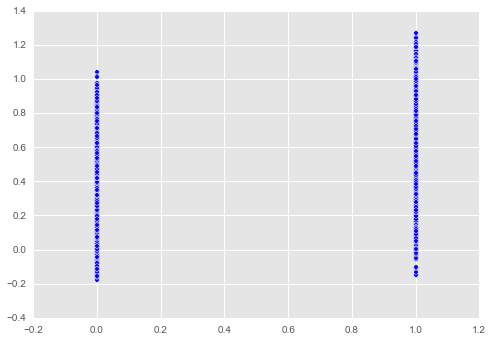

In [76]:
plt.scatter(yEval,t_status_pred)